# The HFM library - A fast marching solver with adaptive stencils

## Part : Seismology
## Chapter : Tilted transversally isotropic metrics

In this notebook, we demonstrate anisotropic fast marching with a class of metrics arising in seismic traveltime tomography. 
The intended use cases are fairly similar to [metrics defined by a Hooke tensor](Seismic.ipynb), which illustrates a closely related model. Under the hood, however, we use a completely different implementation.

**Tilted transversally isotropic models.**
We consider eikonal equations of the following form 
$$
    l(X^2+Y^2,Z^2) + q(X^2+Y^2,Z^2) = 1
$$
where $l$ is a linear form, and $q$ a quadratic form, and where 
$$
    (X,Y,Z) = A \nabla u
$$
for some linear transformation $A$. In dimension two, simply ignore the $Y$ coordinate.

Some algebraic conditions are required on $l$ and $q$ for this equation to make sense. On the other hand, the linear map $A$ is arbitrary.
In the special case where $q=0$, one recovers a Riemannian eikonal equation.

The numerical scheme is based on rewriting this equation as an extremum of a family of Riemannian eikonal equations, in the form
$$
    \max_{t \in [0,1]} \|\nabla u\|_{D(t)} = 1, 
$$
where $D(t)$ depends on the parameters $l$,$q$ and $A$, in addition to $t$. From this point, one can rely on the Eulerian discretization of [Riemannian eikonal equations](../Riemannian.ipynb).

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('TTI','FMM'))

In [2]:
from agd import Eikonal
from agd import LinearParallel as lp
from agd.Metrics import Seismic 
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig; #savefig.dirName = 'Images/TTI'
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np; xp=np
#import scipy.linalg
#from copy import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,lp,Seismic
    Eikonal,ad,lp,Seismic = rreload([Eikonal,ad,lp,Seismic],rootdir="../..")

### 0.1 Optional configuration

In [5]:
from agd import AutomaticDifferentiation as ad; xp,plt,Eikonal = map(ad.cupy_friendly,(xp,plt,Eikonal))

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .


## 1. Two dimensions

### 1.1 Induced norm

In [45]:
n=50
hfmIn = Eikonal.dictIn({
    'model':'TTI2',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.]],
    'factoringRadius':20,
    'seedRadius':0,
    'order':2
})
w=1
hfmIn.SetRect(sides=[[-w,w],[-w,w]],dimx=2*n+1,sampleBoundary=True) # Define the domain
X = hfmIn.Grid() # Horizontal and vertical axis

metric = Seismic.TTI([1.,2.],[[0.,0.2],[0.2,0.]],vdim=2).with_costs(xp.array([1.,2.])).rotate_by(0.5)
hfmIn['metric'] = metric

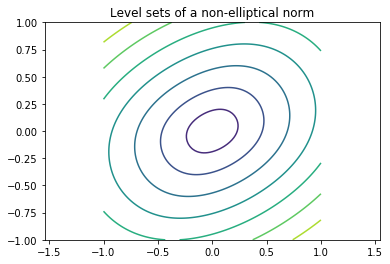

In [50]:
plt.title("Level sets of a non-elliptical norm"); plt.axis('equal')
plt.contour(*X,metric.norm(X));

As described in the introduction, the dual unit ball of a TTI norm is defined by a quartic equation.
We rely on a sequential quadratic programming approach to solve this equation, and check below that it is satisfied in the end.

In [53]:
v=xp.array((0.,1.))
grad = metric.gradient(v)
a=lp.transpose(lp.inverse(metric.inverse_transformation))
lvl = metric._dual_level(lp.dot_AV(a,grad))
print(f"v={v}, grad={grad}, lvl={lvl}")
assert np.abs(lvl)<1e-6

v=[0. 1.], grad=[-0.36112836  1.31741   ], lvl=2.3841858e-07


### 1.2 Fast marching method

In [65]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.07149744033813477 seconds, and 35 iterations.
Post-Processing


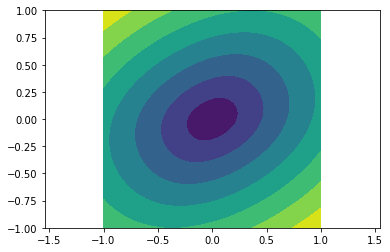

In [66]:
plt.axis('equal')
plt.contourf(*X,hfmOut['values']);

In [68]:
assert norm_infinity(hfmOut['values']-metric.norm(X)) < 0.01

In [11]:
#plt.axis('equal')
#plt.scatter(*hfmOut['spreadedSeeds'].T)
#plt.scatter(0,0)

### 1.3 Construction from Thomsen parameters, and comparison with a Hooke tensor norm

Some examples of elastic materials are reproduced from (Thomsen, 1986). 
These types of elasticity can be dealt with both TTI norms, and more general norms defined by a full Hooke tensor.

In [72]:
th = Seismic.Thomsen
th.ThomsenData.keys()

odict_keys(['Taylor sandstone', 'Mesaverde (4903) mudshale', 'Mesaverde (4912) immature sandstone', 'Mesaverde (4946) immature sandstone', 'Mesaverde (5469.5) silty sandstone', 'Mesaverde (5481.3) immature sandstone', 'Mesaverde (5501) clayshale', 'Mesaverde (5555.5) immature sandstone', 'Mesaverde (5566.3) laminated siltstone', 'Mesaverde (5837.5) immature sandstone', 'Mesaverde (5858.6) clayshale', 'Mesaverde (6423.6) calcareous sandstone', 'Mesaverde (6455.1) immature sandstone', 'Mesaverde (6542.6) immature sandstone', 'Mesaverde (6563.7) mudshale', 'Mesaverde (7888.4) sandstone', 'Mesaverde (7939.5) mudshale', 'Mesaverde shale (350)', 'Mesaverde sandstone (1582)', 'Mesaverde shale (1599)', 'Mesaverde sandstone (1958)', 'Mesaverde shale (1968)', 'Mesaverde sandstone (3512)', 'Mesaverde shale (3511)', 'Mesaverde sandstone (3805)', 'Mesaverde shale (3883)', 'Dog Creek shale', 'Wills Point shale - 1', 'Wills Point shale - 2', 'Cotton Valley shale', 'Pierre shale - 1', 'Pierre shale - 

In [73]:
# Set the center point to exactly (0,0), otherwise hooke norm yields NaN with float32
if Eikonal.dictIn.default_mode=='gpu': X[:,n,n]=0

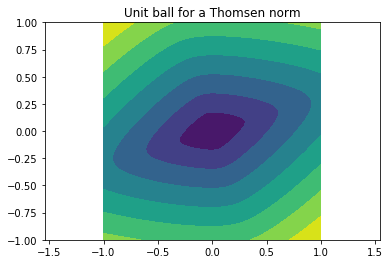

In [85]:
value = th.ThomsenData['Muscovite crystal']
tti   = Seismic.TTI.from_Thomsen(value)[0].extract_xz().rotate_by(0.3)
hooke = Seismic.Hooke.from_Thomsen(value)[0].extract_xz().rotate_by(0.3)

assert np.allclose(tti.norm(X),hooke.norm(X))
plt.title("Unit ball for a Thomsen norm");  plt.axis('equal')
plt.contourf(*X,hooke.norm(X));

The TTI norm and Hooke tensor norm defined from these models coincide up to machine precision.

In [35]:
for key,value in th.ThomsenData.items():
    value = xp.asarray(value)
    tti   = Seismic.TTI.from_Thomsen(value)[0].extract_xz()
    hooke = Seismic.Hooke.from_Thomsen(value)[0].extract_xz()
    
    assert np.allclose(tti.norm(X),hooke.norm(X),atol=1e-5) # atol for float32
    #print(th.get_δ(*value[:4]),value[4],key) # Expected to coincide, according to Thomsen

### 1.4 Taking into account the topography

We reproduce a numerical experiment presented in the notebook [Seismic.ipynb], where the metric is constant, but the domain is a diffeomorphically mapped rectangle.

In [123]:
def h(x,z,alpha=0.5): return ad.array([x, z + alpha*z*np.sin(np.pi*x)])

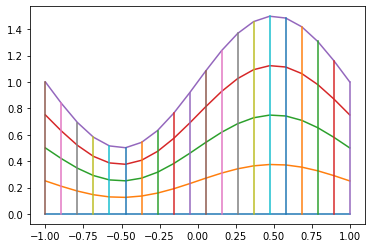

In [124]:
X = np.linspace(-1,1,20)
Z = np.linspace(0,1,5)
for z in Z: plt.plot(*h(X,z)) 
for x in X: plt.plot(*h(x+0.*Z,Z))

In [127]:
hfmIn = Eikonal.dictIn({
    'model':'SeismicTopographic2',
    'exportValues':1,
    'seed':[0.,0.5],
})

# Define the domain
hfmIn.SetRect(sides=[[-1,1],[0,1]],dimx=101)
hfmIn.SetUniformTips((6,6))

X0 = hfmIn.Grid() # Grid coordinates (horizontal and vertical)
X = h(*X0) # Physical coordinates

In [132]:
X0_ad = ad.Dense.identity(constant=X0,shape_free=(2,))
Jac = np.moveaxis(h(*X0_ad).gradient(),0,1)

In [134]:
mica = Seismic.TTI.mica[0]
hfmIn['metric'] = mica.extract_xz().rotate_by(-np.pi/6).inv_transform(Jac) 

In [141]:
hfmIn['metric'].with_cost(1.5)

AssertionError: 

In [136]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)


AssertionError: 

## 2 Three dimensions

In [110]:
hfmIn_Constant = Eikonal.dictIn({
    'model':'TTI3',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.,0.]],
    'factoringRadius':20,
    'seedRadius':2,
#    'order':2
#    'exportGeodesicFlow':1,
})

hfmIn_Constant.SetRect(sides=[[-1,1],[-1,1],[-1,1] ],dimx=31,sampleBoundary=True) # Define the domain
X = hfmIn_Constant.Grid() 

metric = Seismic.TTI([1.,1],[[0.5,0.1],[0.1,-0.2]],vdim=3).rotate_by(0.5,axis=(1,2,3))
hfmIn_Constant['metric'] = metric

In [111]:
hfmOut = hfmIn_Constant.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.10699963569641113 seconds, and 22 iterations.
Post-Processing


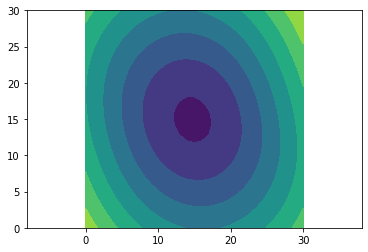

In [112]:
plt.axis('equal')
plt.contourf(hfmOut['values'][:,5,:]);

The largest difference between the exact value and the fast marching result is in the corners, because several of the stencil points may be outside the domain.

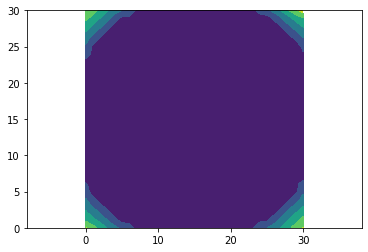

In [115]:
plt.axis('equal')
plt.contourf(hfmOut['values'][:,5,:]-metric.norm(X)[:,5,:]);

In [117]:
assert norm_infinity(hfmOut['values'] - metric.norm(X)) < 2e-2